In [25]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report, plot_confusion_matrix

def minMaxScaleContinuous(continuousList):
    return pd.DataFrame(MinMaxScaler().fit_transform(data[continuousList])
                             ,columns=list(data[continuousList].columns)
                             ,index = data[continuousList].index)

def createDiscreteDummies(discreteList):
    return pd.get_dummies(data[discreteList], dummy_na = True, prefix_sep = "::", drop_first = False)

# save the model to disk
def saveModel(filename, model):
    joblib.dump(model, filename)
 
 
# load the model from disk
def loadModel(filename):
    return joblib.load(filename)

'''Function to print model accuracy information'''
def printAccuracyInfo(model, X_test, y_test):
    print(y_test.value_counts())
    # Make predictions against the test set
    pred = model.predict(X_test)

    # Show the confusion matrix
    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))

    # Find the accuracy scores of the predictions against the true classes
    print("accuracy: %0.3f" % accuracy_score(y_test, pred))
    print("recall: %0.3f" % recall_score(y_test, pred, pos_label=True))
    print("precision: %0.3f" % precision_score(y_test, pred, pos_label=True))
    print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1, pos_label=True))
    print(classification_report(y_test,pred))

    
'''Function to print confusion matrix for a model
   You may need to run this to update to scikit-learn version 0.22.1
         !pip install -U scikit-learn --user
'''
def plotConfusionMatrix (negative_label, positive_label, model, X_test, y_test):
    titles_options = [("Confusion matrix, without normalization", None,'d'),
                      ("Normalized confusion matrix", 'true','.3g')]
    for title, normalize,val_frmt in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=[negative_label,positive_label],
                                     cmap=plt.cm.Blues,
                                     values_format=val_frmt,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        disp.ax_.set_xlabel('Predicted')
        disp.ax_.set_ylabel('Actual')

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
%matplotlib inline
sns.set(style='ticks', palette='Set2')

# Part 1: Decision Tree

In [26]:
print("Reading in pickle file...")

data, discrete_features, continuous_features, ret_cols = pickle.load( open( "../data/clean_data.pickle", "rb" ) )

# Create the outcome
data["default"] = data.loan_status.isin(["Charged Off", "Default"])
# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

discrete_features_touse=discrete_features
continuous_features_touse = continuous_features

Reading in pickle file...


### Split training and test data

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Create dummies for categorical features and concatenate with continuous features for X or predictor dataframe

# Use this line of code if you do not want to scale the continuous features
#X_continuous = data[continuous_features_touse]

# use this line if you want to scale the continuous features using the MinMaxScaler in the function defined above
X_continuous = minMaxScaleContinuous(continuous_features_touse)

# create numeric dummy features for the discrete features to be used in modeling
X_discrete = createDiscreteDummies(discrete_features_touse)

#concatenate the continuous and discrete features into one dataframe
X = pd.concat([X_continuous, X_discrete], axis = 1)

# this is the target variable 
target_col = 'default'
y=data[target_col]

# create a test and train split of the transformed data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.4)

print("Population:\n",y.value_counts())
print("Train:\n", y_train.value_counts())
print("Test:\n", y_test.value_counts())

Population:
 False    613255
True     164011
Name: default, dtype: int64
Train:
 False    367757
True      98602
Name: default, dtype: int64
Test:
 False    245498
True      65409
Name: default, dtype: int64


### Now we will get a model with best fit parameters using GridSearchCV

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

parameters = {'criterion'   : ["gini", "entropy"],
              'max_depth'   : [3]
             }

print("Parameter grid:\n{}".format(parameters),'\n')

grid =  GridSearchCV(DecisionTreeClassifier(), parameters, cv=10, return_train_score=True, scoring='roc_auc', n_jobs=-1)

# perform grid search cv on training data.  The CV algorithm divides this into training and validation
dt_model = grid.fit(X_train, y_train)

print('best params ',dt_model.best_params_,'\n')
print('best estimator ',dt_model.best_estimator_,'\n')
print('best validation score ', dt_model.best_score_,'\n')
print('scoring method ', dt_model.scorer_)

print("Test set accuracy score: {:.7f}".format(dt_model.score(X_test, y_test)))

saveModel('dt_model', dt_model)

Parameter grid:
{'criterion': ['gini', 'entropy'], 'max_depth': [3]} 

best params  {'criterion': 'entropy', 'max_depth': 3} 

best estimator  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best') 

best validation score  0.9263759729490928 

scoring method  make_scorer(roc_auc_score, needs_threshold=True)
Test set accuracy score: 0.9261057


### Now we can determine the best features

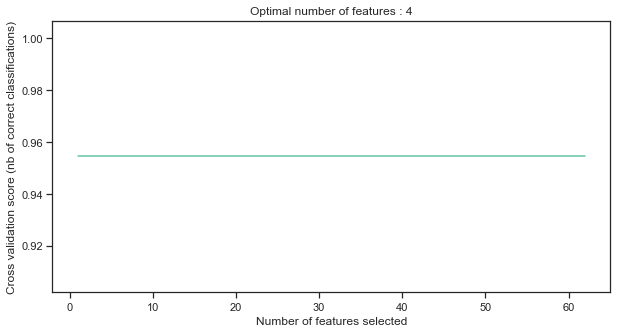

In [31]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV

dt = DecisionTreeClassifier(max_depth=3, criterion="gini")

rfecv = RFECV(estimator=dt, min_features_to_select = 4, cv=10, n_jobs=-1)
rfecv.fit(X_train, y_train)

# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title("Optimal number of features : %d" % rfecv.n_features_)
plt.show()

In [32]:
# create new training and test datasets with the selected features only

rfecv_selected_train = pd.DataFrame(rfecv.transform(X_train)
                                    ,columns=list(X_train.columns[rfecv.get_support()])
                                    ,index=X_train.index)

rfecv_selected_test = pd.DataFrame(rfecv.transform(X_test)
                                    ,columns=list(X_test.columns[rfecv.get_support()])
                                    ,index=X_test.index)

print("train:", rfecv_selected_train.shape)
print("test:", rfecv_selected_test.shape)

train: (466359, 4)
test: (310907, 4)


In [33]:
# look at the ranking of each feature after using RFECV
pd.Series(rfecv.ranking_, index=X_train.columns).sort_values(ascending=True).head(10)

recoveries             1
funded_amnt            1
emp_length::9 years    1
total_pymnt            1
emp_length::8 years    2
emp_length::7 years    3
emp_length::6 years    4
emp_length::5 years    5
emp_length::4 years    6
dti                    7
dtype: int64

### Visualize Performance

In [28]:
dt_model = loadModel('dt_model')
# example use of printAccuracyInfo using gbc_model and X_test
# note: if you trained model using rfecv_selected_train, you need to call the function with rfecv_selected_test for X_test
printAccuracyInfo(dt_model, X_test, y_test)

False    245498
True      65409
Name: default, dtype: int64
confusion matrix:
[[245385    113]
 [ 14018  51391]]
accuracy: 0.955
recall: 0.786
precision: 0.998
f-measure: 0.879
              precision    recall  f1-score   support

       False       0.95      1.00      0.97    245498
        True       1.00      0.79      0.88     65409

    accuracy                           0.95    310907
   macro avg       0.97      0.89      0.93    310907
weighted avg       0.96      0.95      0.95    310907



Confusion matrix, without normalization
[[245385    113]
 [ 14018  51391]]
Normalized confusion matrix
[[9.99539711e-01 4.60288882e-04]
 [2.14313015e-01 7.85686985e-01]]


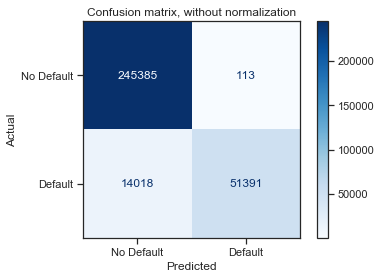

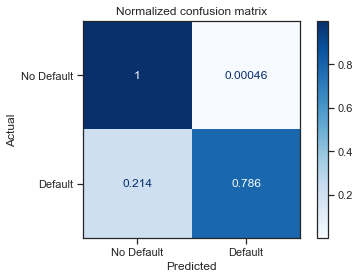

In [30]:
# example use of plotConfusionMatrix using gbc_model and X_test
# note: if you trained model using rfecv_selected_train, you need to call the function with rfecv_selected_test for X_test
plotConfusionMatrix('No Default', 'Default', dt_model, X_test, y_test)